In [2]:
import pyemma
import numpy as np
import pyemma.coordinates as coor
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import os
from matplotlib.pyplot import cm
from collections import OrderedDict
import mdtraj as md
import itertools
import time
import indices
from indices.base import BaseComparisons as bc
from indices.faith import Faith as Fai
import scipy.cluster.hierarchy as shc
from matplotlib import gridspec
from matplotlib import pyplot
import mdtraj
import seaborn as sns

## Let's try it...

In [3]:
Threshold = 0.6
traj = md.load_dcd('../proteinG_3gb1/yhalfres_0_0/trajectory.00.dcd',top='../proteinG_3gb1/3GB1.pdb')
topfile=traj.top
feat = coor.featurizer(topfile)
residues = np.arange(0,56)
pairs = []                                                                                 
for i,r1 in enumerate(residues):
    for r2 in residues[i+1::2]:
        pairs.append([r1,r2])
pairs = np.array(pairs)
feature=feat.add_residue_mindist(pairs, scheme='closest-heavy',threshold=Threshold,periodic=False)
inp = pyemma.coordinates.load('../proteinG_3gb1/yhalfres_0_0/trajectory.00.dcd', features=feat)

In [4]:
inp=inp[::10]

In [5]:
# %%timeit -n1 -r1 

all_start = time.time()
all_input = list(itertools.combinations(inp, 2))
batch_size=1000000
inp_sliced=[all_input[i*batch_size:(i+1)*batch_size] for i in range(int(len(all_input)/batch_size))]
if int(len(inp_sliced)) < len(all_input)/batch_size:
    inp_sliced.append(all_input[len(inp_sliced)*batch_size:])
for i in range(len(inp_sliced)):
    temp_start = time.time()
    temp_c = np.zeros((int(len(inp_sliced[i])),3))
    temp_input = np.array(inp_sliced[i])
    product = temp_input.reshape(-1,2,temp_input.shape[-1]).sum(1)
    for row in range(3):
        temp_c[:,row] = np.sum(product==row,axis=1)
    if i == 0:
        all_c = temp_c
    else:
        all_c = np.concatenate((all_c,temp_c),axis=0)
    print('all_c shape =', all_c.shape)
    temp_end = time.time()
    temp_time = temp_end - temp_start
    print('step {} time ='.format(i),round(temp_time,2),'s')


###calculate similarity
simi = all_c[:,0]+all_c[:,2]
###try Faith
disimi = all_c[:,1]
denominate = all_c[:,0]+all_c[:,1]+all_c[:,2]
w_p = simi/denominate
simi_matrix = np.zeros((len(inp),len(inp)))
indices = np.triu_indices(len(inp),k=1)
indices = (indices[1],indices[0])
simi_matrix[indices] = simi
print('final matrix shape = ', simi_matrix.shape)
all_end = time.time()
all_time = all_end - all_start
print('total time =', round(all_time,2),'s')

all_c shape = (499500, 3)
step 0 time = 4.91 s
final matrix shape =  (1000, 1000)
total time = 4.96 s


In [6]:
simi_matrix

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [724.,   0.,   0., ...,   0.,   0.,   0.],
       [714., 702.,   0., ...,   0.,   0.,   0.],
       ...,
       [680., 684., 666., ...,   0.,   0.,   0.],
       [684., 680., 674., ..., 706.,   0.,   0.],
       [684., 680., 680., ..., 698., 734.,   0.]])

In [7]:
np.unravel_index(np.argmax(simi, axis=None),simi.shape)
simi_matrix

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [724.,   0.,   0., ...,   0.,   0.,   0.],
       [714., 702.,   0., ...,   0.,   0.,   0.],
       ...,
       [680., 684., 666., ...,   0.,   0.,   0.],
       [684., 680., 674., ..., 706.,   0.,   0.],
       [684., 680., 680., ..., 698., 734.,   0.]])

In [8]:
import pandas  as pd
all_start=time.time()
df = pd.DataFrame(simi_matrix,columns=pd.MultiIndex.from_tuples([('{}'.format(i),'{}'.format(i)) for i in range(1,len(inp)+1)],names=['cluster', 'frame']))
inp_copy=inp
dic={}
hie_tree=[]
dentrom=[]
while df.shape[0] > 2:
    ###update df
    frame_column=[i[1] for i in df.columns.to_list()]
    hie_tree.append(frame_column)
    new_max=np.argmax(df, axis=None)     ###2.5s

    del_index = np.unravel_index(new_max, df.shape)
    max_value = df.to_numpy()[del_index[0]][del_index[1]] ###0.1s

    ###get temp inp
    delete_row=[int(i) for i in df.columns[del_index[0]][1].split(',') ]
    delete_cluster_row=[int(i) for i in df.columns[del_index[0]][0].split(',')]
    delete_column=[int(i) for i in df.columns[del_index[1]][1].split(',') ]
    delete_cluster_column=[int(i) for i in df.columns[del_index[1]][0].split(',')]
    dentrom.append([*delete_cluster_column,*delete_cluster_row])

    delete_all=delete_column+delete_row
    insert_index='{}'.format(delete_all)[1:-1]   ###0.1s
    insert_cluster_index='{}'.format(2*len(inp) - df.shape[0]+1)
    df.drop(columns=[('{}'.format(delete_cluster_column)[1:-1],'{}'.format(delete_column)[1:-1]),('{}'.format(delete_cluster_row)[1:-1],'{}'.format(delete_row)[1:-1])],axis=1,inplace=True)
    df.drop(index=[*del_index],axis=0,inplace=True)
    df.reset_index(drop=True,inplace=True)
    temp_w_sim=[]            ###1s

    ###get temp inp
   # print(df.columns)
    frame_column=[i[1] for i in df.columns.to_list() ]
    columns=[[int(d) for d in [*i.split(',')]] for i in frame_column]
    temp_inp=[[inp_copy[d-1] for d in m] for m in columns]    ###0.1s

    ###perform comparison
    
    for i in temp_inp:
        compare=bc(np.concatenate(([inp_copy[d-1] for d in delete_all],i),axis=0))
        temp_w_sim.append(compare.total_w_sim)         ###1s

#     temp_start = time.time()
  #  inp_copy = temp_inp
    temp_w_sim=[0]+temp_w_sim
    df.loc[-1] = [0]*df.shape[1] # adding a row
    df.index = df.index + 1  # shifting index
    df = df.sort_index()  # sorting by index
   # print(df.shape)
    if df.shape[0] % 100 == 0:
        all_end = time.time()
        all_time = all_end - all_start
        print('merge {} clusters time ='.format(df.shape[0]), round(all_time,2),'s')
    df.insert(loc=0, column=(insert_cluster_index,insert_index), value=temp_w_sim)

    dic[insert_index]=max_value
#     temp_end = time.time() 
#     temp_time = temp_end - temp_start           
#     print('step {} time = '.format(df.shape[0]),temp_time)  ###1s
last_two = [int(i[0]) for i in df.columns.to_list()]
dentrogram = np.vstack(dentrom)-np.ones((1,2))
values = np.max(simi_matrix)-np.array([*dic.values()],ndmin=2)+2
num_frames = np.array([len(i) for i in [[int(d) for d in [*k.split(',')]] for k in list(dic.keys())]],ndmin=2)
tree = np.hstack((dentrogram,values.T,num_frames.T))
tree = np.vstack((tree, [[last_two[0]-1,last_two[1]-1,np.max(simi_matrix)-df.to_numpy()[1][0],len(inp)]]))

merge 900 clusters time = 10.32 s
merge 800 clusters time = 20.33 s
merge 700 clusters time = 28.92 s
merge 600 clusters time = 37.39 s
merge 500 clusters time = 45.04 s
merge 400 clusters time = 52.16 s
merge 300 clusters time = 58.51 s
merge 200 clusters time = 65.16 s
merge 100 clusters time = 72.13 s


In [37]:
def plot_simi_threshold(tree,p,min_simi,save=False):
    plt.figure(figsize=(20, 8))
    dend = shc.dendrogram(tree,p=p,truncate_mode='lastp')
    plt.axhline(y=70, color='r', linestyle='-')
    plt.xlabel('Num_samples')
    plt.ylabel('Simi_value')
    if save:
        plt.savefig('simi_threshold_tree.png')
def plot_test_result(true_rmsd,hie_tree,cluster_step,save=False):
    colors = ['grey', 'purple', 'blue', 'green', 'orange', 'red',
             'black','brown','navy','indigo','cyan','teal','violet','royalblue']
    fig, ax = plt.subplots(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[15, 1]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    label_index = [[int(i)-1 for i in hie_tree[cluster_step][d].split(',')] for d in range(len(hie_tree[cluster_step]))]
    label_index = sorted(label_index, key=lambda x:len(x), reverse=True)
    if len(label_index) > 10:
        label_index = label_index[:10]
    test_rmsd = [[true_rmsd[i] for i in label_index[d]] for d in range(len(label_index))]
    for index,i in enumerate(test_rmsd):
        ax0.scatter(label_index[index],i,marker='.',color=colors[index])
    percentage=[len(i)/len(true_rmsd) for i in test_rmsd]
    sum_percentage = [0.0]+[sum(percentage[:i]) for i in range(1,len(percentage))]+[1.0]
    ax0.set_xlabel('Sample')
    ax0.set_ylabel('RMSD')
    cmap = mpl.colors.ListedColormap(colors[:len(test_rmsd)])
    print(colors[:len(test_rmsd)])
    norm = mpl.colors.BoundaryNorm(sum_percentage, cmap.N)
    cb2 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                    norm=norm,
                                    boundaries=sum_percentage,
                                    ticks=sum_percentage+[1.0],
                                    spacing='proportional')
    cb2.set_label('Cluster samples ratio')
    if save:
        plt.savefig('simi_threshold_tree.png')
    return label_index

['grey', 'purple', 'blue', 'green', 'orange', 'red', 'black', 'brown', 'navy', 'indigo']


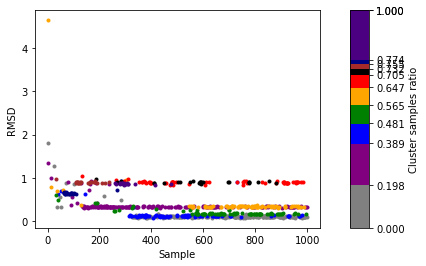

In [41]:
traj = md.load_dcd('../proteinG_3gb1/yhalfres_0_0/trajectory.00.dcd',top='../proteinG_3gb1/3GB1.pdb')
topfile=traj.top
pdb=md.load_pdb('../proteinG_3gb1/3GB1.pdb')
all_CA=topfile.select("backbone==1")
traj=traj[::10]
true_rmsd=md.rmsd(traj,pdb,atom_indices=all_CA)
label_index = plot_test_result(true_rmsd,hie_tree,-60)

(0.0, 2.0)

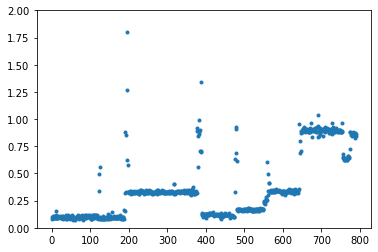

In [42]:
label_concate = np.concatenate(label_index)
traj = md.load_dcd('../proteinG_3gb1/yhalfres_0_0/trajectory.00.dcd',top='../proteinG_3gb1/3GB1.pdb')
topfile=traj.top
pdb=md.load_pdb('../proteinG_3gb1/3GB1.pdb')
all_CA=topfile.select("backbone==1")
rmsd=md.rmsd(traj,pdb,atom_indices=all_CA)
traj_cluster=traj[::10][label_concate]
cluster_rmsd=md.rmsd(traj_cluster,pdb,atom_indices=all_CA)
plt.scatter(range(len(cluster_rmsd)),list(cluster_rmsd),marker='.')
plt.ylim(0,2)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
(313236,)


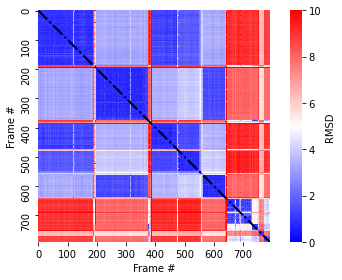

In [43]:
rmsd_2d=np.zeros((len(traj_cluster),len(traj_cluster)))
upper_indices = np.triu_indices(len(traj_cluster),k=0)
lower_indices = (upper_indices[1],upper_indices[0])
r2d = []
for i in range(len(traj_cluster)):
    r2d.append(md.rmsd(traj_cluster[i:],traj_cluster[i],atom_indices=all_CA))
    if i % 50 == 0:
        print(i)
print(np.concatenate(r2d).shape)
rmsd_2d[lower_indices] = np.concatenate(r2d)
rmsd_2d[upper_indices] = np.concatenate(r2d)
sns.heatmap(rmsd_2d*10,square=True,xticklabels=100,yticklabels=100,cmap='bwr',cbar_kws={'label':'RMSD'},vmin=0,vmax=10)
plt.plot(range(1000),range(1000),'-.',color='k',linewidth=2)
plt.xlabel("Frame #")
plt.ylabel("Frame #")
ax = plt.gca()
ax.tick_params(direction='out')
plt.tight_layout()

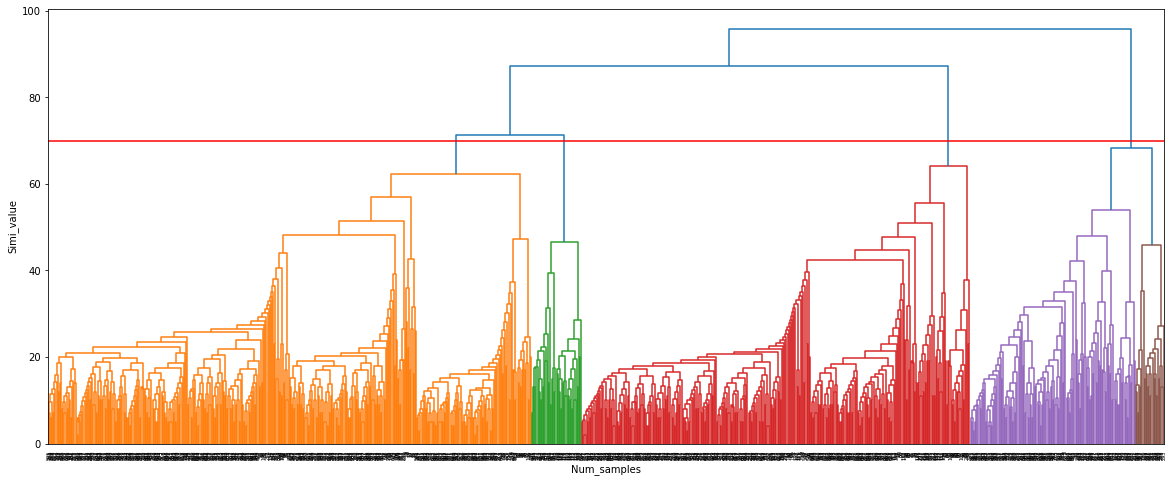

In [418]:
plot_simi_threshold(tree,2000,70)

(0.0, 1.5)

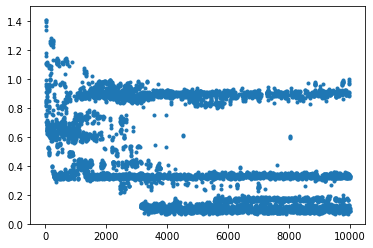

In [20]:
traj = md.load_dcd('../proteinG_3gb1/yhalfres_0_0/trajectory.00.dcd',top='../proteinG_3gb1/3GB1.pdb')
topfile=traj.top
pdb=md.load_pdb('../proteinG_3gb1/3GB1.pdb')
len(traj)
all_CA=topfile.select("backbone==1")
all_CA
rmsd=md.rmsd(traj,pdb,atom_indices=all_CA)
#list(rmsd)
plt.scatter(range(len(rmsd)),list(rmsd),marker='.')
plt.ylim(0,1.5)

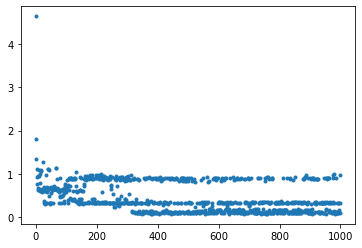

In [21]:
traj=traj[::10]
true_rmsd=md.rmsd(traj,pdb,atom_indices=all_CA)
#list(rmsd)
plt.scatter(range(len(true_rmsd)),list(true_rmsd),marker='.')

In [208]:
def correct_ratio(x):
    unfold = np.sum((x>0.8) & (x<1.8))/x.shape[0]
    intermediate = np.sum((x>0.25) & (x<0.45))/x.shape[0]
    fold = np.sum((x>0.0) & (x<0.25))/x.shape[0]
    molten = np.sum((x>0.45) & (x<0.8))/x.shape[0]
    other = 1-unfold-intermediate-fold-molten
    ratio = [round(unfold,4),round(intermediate,4),round(fold,4),round(molten,4),round(other,4)]
    return ratio

In [206]:
all_clust=[[int(d) for d in [*i.split(',')]] for i in list(dic.keys())]
ave_rmsd = []
all_rmsd = []
for index,i in enumerate(all_clust):
    
    traj_comp=traj[[np.array(i)-1]]
    rmsd=md.rmsd(traj_comp,pdb,atom_indices=all_CA)
    ave_rmsd.append(np.average(rmsd))
    all_rmsd.append(rmsd)
    print(rmsd)

/home/liweichang/anaconda3/envs/msm/lib/python3.7/site-packages/mdtraj/core/trajectory.py:1129: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  xyz = self.xyz[key]
/home/liweichang/anaconda3/envs/msm/lib/python3.7/site-packages/mdtraj/core/trajectory.py:1130: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  time = self.time[key]


[0.31976464 0.33135805]
[0.17163347 0.15688609]
[0.0929341  0.11023112]
[0.17410065 0.1754465 ]
[0.15701109 0.17148258]
[0.88299316 0.87756145]
[0.32051554 0.33053842]
[0.31985962 0.33764762]
[0.33260357 0.33129618]
[0.31357715 0.33238515]
[0.09612995 0.11547884]
[0.34775263 0.3558367 ]
[0.1155726  0.11764871]
[0.11883549 0.12217686]
[0.17880735 0.16391711]
[0.17268951 0.16569938]
[0.1174917 0.1221841]
[0.15193406 0.15070012]
[0.31288582 0.314653  ]
[0.16289201 0.16977468]
[0.34609345 0.32634017]
[0.3419993  0.33577523]
[0.10406038 0.09673111]
[0.8924123  0.92363656]
[0.32074988 0.34582606]
[0.16419034 0.16459808]
[0.8768226 0.8926591]
[0.07949243 0.08370326]
[0.32293034 0.32686472]
[0.88946587 0.8887451 ]
[0.88946587 0.8887451  0.8768226  0.8926591 ]
[0.62710524 0.621771  ]
[0.31913877 0.3218244 ]
[0.32697868 0.33377954]
[0.33113307 0.3233214 ]
[0.33257058 0.3338677 ]
[0.08715513 0.09639744]
[0.11653522 0.11300008]
[0.15707052 0.15915957]
[0.3289146 0.3355102]
[0.16795172 0.17074451]


[0.32428095 0.31752917 0.32074988 0.34582606 0.32009912 0.3191883 ]
[0.11621328 0.10153231 0.08636606 0.11978554 0.114653   0.10064416]
[0.3419993  0.33577523 0.31985962 0.33764762 0.32432735 0.324543  ]
[0.0929341  0.11023112 0.09847107 0.106768   0.09653373 0.08405167
 0.09417411 0.09317128]
[0.11971045 0.12355845 0.11936169 0.11496509 0.11850312]
[0.1635785  0.17137767 0.17163347 0.15688609 0.17268951 0.16569938
 0.15905724 0.16860709 0.17368346 0.16408823]
[0.10209899 0.09442477 0.10406038 0.09673111 0.09339547 0.11136728
 0.09762346]
[0.1731457  0.16299528 0.15701109 0.17148258 0.17402042 0.17020467
 0.1616545 ]
[0.32485056 0.3319385  0.31976464 0.33135805 0.32430762 0.33272356
 0.3353528  0.34087008 0.3124422  0.32410526 0.31933147 0.328234
 0.32082483]
[0.32442626 0.33069482 0.3257995  0.3348818  0.3266377  0.33773234
 0.3307109 ]
[0.89493924 0.8740338  0.88299316 0.87756145 0.91025025 0.9087288
 0.9078324  0.9113744  0.9238757  0.8881688 ]
[0.0917568  0.09213834 0.0891664  0.08

[0.08571368 0.0907978 ]
[0.09264486 0.09026583]
[0.32921642 0.31437492]
[0.34200686 0.3340472 ]
[0.08490159 0.09442694 0.08148802 0.08447608 0.10520102 0.11951967]
[0.1731457  0.16299528 0.15701109 0.17148258 0.17402042 0.17020467
 0.1616545  0.1741957  0.16202068 0.159166   0.16344559 0.16725183
 0.15707052 0.15915957 0.17358185 0.16501719 0.16419034 0.16459808]
[0.12321284 0.12751208 0.1155726  0.11764871 0.13910447 0.13041928
 0.11880912]
[0.33496928 0.3285843  0.3289146  0.3355102  0.34495708 0.3212774
 0.33913726 0.3300001  0.32551125 0.33164552 0.34480995 0.33519778]
[0.32485056 0.3319385  0.31976464 0.33135805 0.32430762 0.33272356
 0.3353528  0.34087008 0.3124422  0.32410526 0.31933147 0.328234
 0.32082483 0.33060232 0.3225006  0.3383073  0.32759145]
[0.9109303  0.8943363  0.9039898  0.89496946 0.8926081  0.90788436
 0.9137742  0.9060554  0.88200134 0.91875005]
[0.10351957 0.08286736 0.08504428 0.07741816 0.08788443]
[0.33942014 0.329863   0.3374787  0.32840618 0.3285752  0.344

[0.33223614 0.33429873 0.32293034 0.32686472 0.33925393 0.33228534
 0.35034978 0.32686242 0.33416158 0.35967267 0.34993306 0.34683824
 0.32773197 0.3343395  0.32457405]
[0.32485056 0.3319385  0.31976464 0.33135805 0.32430762 0.33272356
 0.3353528  0.34087008 0.3124422  0.32410526 0.31933147 0.328234
 0.32082483 0.33060232 0.3225006  0.3383073  0.32759145 0.32359034
 0.31848815 0.33178946 0.32576102 0.3291446  0.3169694  0.3399658 ]
[0.32339388 0.33709902 0.30964667 0.3087458  0.3134481  0.33012766
 0.32311952 0.3340158 ]
[0.11060251 0.10557785 0.11837141 0.10679479 0.10413694 0.09792791
 0.1017508  0.09514775]
[0.08056492 0.09725854 0.09243948 0.10853095 0.1025291  0.09899611
 0.08826418 0.10894316]
[0.0929341  0.11023112 0.09847107 0.106768   0.09653373 0.08405167
 0.09417411 0.09317128 0.09548151 0.08867688 0.0995656  0.1156545
 0.07938181 0.10226366]
[0.0901299  0.07523788 0.10347877 0.08201464 0.07073364 0.0834808 ]
[0.32697868 0.33377954 0.34609345 0.32634017 0.33688453 0.32739404

[0.33942014 0.329863   0.3374787  0.32840618 0.3285752  0.3441077
 0.33230132 0.33446088 0.34438947 0.33904365 0.32898295 0.33139157
 0.33895    0.3453443  0.33111373 0.3365054  0.34013486 0.35735038
 0.34362435 0.34346354 0.33476198 0.34200686 0.3340472  0.334048
 0.33942696]
[0.33257058 0.3338677  0.31357715 0.33238515 0.31780213 0.32576457
 0.33288383 0.34006456 0.33055964 0.33662927 0.33732688 0.33144993
 0.33113307 0.3233214  0.3325368  0.32482708 0.33549598 0.3349595
 0.3330483  0.33789748 0.32982418 0.32571355 0.32518652 0.33696035
 0.3440578  0.32214195 0.33116826 0.31730834 0.33496928 0.3285843
 0.3289146  0.3355102  0.34495708 0.3212774  0.33913726 0.3300001
 0.32551125 0.33164552 0.34480995 0.33519778 0.30868492 0.3238433
 0.3058265  0.3359594  0.32338968 0.34775263 0.3558367 ]
[0.8998297  0.88481575 0.88164103 0.88367844 0.89301664]
[0.10351957 0.08286736 0.08504428 0.07741816 0.08788443 0.08912513
 0.08761039 0.07928908 0.1067782  0.07949243 0.08370326 0.08357865
 0.093755

[0.89493924 0.8740338  0.88299316 0.87756145 0.91025025 0.9087288
 0.9078324  0.9113744  0.9238757  0.8881688  0.8817203  0.90563756
 0.8952467  0.89370483 0.9097892  0.9112789  0.88946587 0.8887451
 0.8768226  0.8926591  0.881877   0.88114417 0.88088226 0.916488
 0.88930166 0.91229814 0.9611762  0.88737744 0.89631385]
[0.89225507 0.90910774 0.8820699  0.87399685 0.91549575 0.91154623
 0.8964437  0.92301583 0.89964956]
[0.8773448  0.8772612  0.8696496  0.8540657  0.8643596  0.85881335
 0.8467836 ]
[0.0929341  0.11023112 0.09847107 0.106768   0.09653373 0.08405167
 0.09417411 0.09317128 0.09548151 0.08867688 0.0995656  0.1156545
 0.07938181 0.10226366 0.0956775  0.07798012 0.09692317 0.10009714
 0.1172915  0.09772319 0.09038725 0.08610933 0.08515795 0.09506968
 0.10943664 0.09158365 0.10074496 0.10927656 0.1161177  0.10342675
 0.0901299  0.07523788 0.10347877 0.08201464 0.07073364 0.0834808
 0.0917568  0.09213834 0.0891664  0.0891473  0.1042605  0.09612145
 0.1093289  0.11473555 0.09508

[0.32371557 0.3266381  0.32370505 0.3244964  0.3347154  0.3197838
 0.31157044 0.31580523 0.31778562 0.36730677 0.31347916]
[0.11488152 0.13609652 0.12551881 0.12002528 0.10144976 0.1142435
 0.12616567 0.11287824 0.11661294 0.12441771 0.12351599 0.0921021
 0.12561321 0.11869324 0.12321284 0.12751208 0.1155726  0.11764871
 0.13910447 0.13041928 0.11880912 0.13072813 0.13346688 0.1333188
 0.12297378 0.12860256 0.12380079 0.12537436 0.1274378  0.14482787
 0.11545702 0.11653522 0.11300008 0.1174917  0.1221841  0.11683471
 0.12294441 0.12102566 0.11694951 0.12230446 0.12554052 0.11352152
 0.1212388  0.11883549 0.12217686 0.11434422 0.12340564 0.09821478
 0.11385946 0.13914461 0.07863689 0.10410489 0.11050208 0.11311155
 0.10033437 0.10888625 0.11427033 0.12935464 0.10878861 0.12109993
 0.13513763 0.1166217  0.11807179 0.11971045 0.12355845 0.11936169
 0.11496509 0.11850312 0.1197002  0.12424733 0.11879937 0.13738032
 0.12155696 0.10614732 0.08865076 0.10408787 0.09894931 0.1085937
 0.1106025

[0.08056492 0.09725854 0.09243948 0.10853095 0.1025291  0.09899611
 0.08826418 0.10894316 0.08571368 0.0907978  0.09293044 0.15406536
 0.11995488 0.09091027 0.09026659 0.10994587 0.08578438 0.09740691
 0.09598529 0.09807805 0.09523576 0.10503188 0.09891695 0.09276683
 0.089158   0.0929341  0.11023112 0.09847107 0.106768   0.09653373
 0.08405167 0.09417411 0.09317128 0.09548151 0.08867688 0.0995656
 0.1156545  0.07938181 0.10226366 0.0956775  0.07798012 0.09692317
 0.10009714 0.1172915  0.09772319 0.09038725 0.08610933 0.08515795
 0.09506968 0.10943664 0.09158365 0.10074496 0.10927656 0.1161177
 0.10342675 0.0901299  0.07523788 0.10347877 0.08201464 0.07073364
 0.0834808  0.0917568  0.09213834 0.0891664  0.0891473  0.1042605
 0.09612145 0.1093289  0.11473555 0.09508186 0.08159997 0.10209899
 0.09442477 0.10406038 0.09673111 0.09339547 0.11136728 0.09762346
 0.12166058 0.08956049 0.07593182 0.10326922 0.10875542 0.11309468
 0.09180133 0.10280909 0.11880166 0.09467117 0.09135577 0.1075156

[0.08056492 0.09725854 0.09243948 0.10853095 0.1025291  0.09899611
 0.08826418 0.10894316 0.08571368 0.0907978  0.09293044 0.15406536
 0.11995488 0.09091027 0.09026659 0.10994587 0.08578438 0.09740691
 0.09598529 0.09807805 0.09523576 0.10503188 0.09891695 0.09276683
 0.089158   0.0929341  0.11023112 0.09847107 0.106768   0.09653373
 0.08405167 0.09417411 0.09317128 0.09548151 0.08867688 0.0995656
 0.1156545  0.07938181 0.10226366 0.0956775  0.07798012 0.09692317
 0.10009714 0.1172915  0.09772319 0.09038725 0.08610933 0.08515795
 0.09506968 0.10943664 0.09158365 0.10074496 0.10927656 0.1161177
 0.10342675 0.0901299  0.07523788 0.10347877 0.08201464 0.07073364
 0.0834808  0.0917568  0.09213834 0.0891664  0.0891473  0.1042605
 0.09612145 0.1093289  0.11473555 0.09508186 0.08159997 0.10209899
 0.09442477 0.10406038 0.09673111 0.09339547 0.11136728 0.09762346
 0.12166058 0.08956049 0.07593182 0.10326922 0.10875542 0.11309468
 0.09180133 0.10280909 0.11880166 0.09467117 0.09135577 0.1075156

In [209]:
correct_ratio(true_rmsd)

[0.252, 0.307, 0.349, 0.091, 0.001]

In [425]:
accuracy=[]
for i in range(len(all_rmsd)):
    if len(all_rmsd[i])>1:
        ratio = correct_ratio(all_rmsd[i])
        print(len(all_rmsd[i]),ratio)#,'|',[*dic.keys()][i])
        accuracy.append(np.max(ratio))

2 [0.0, 1.0, 0.0, 0.0, 0.0]
2 [0.0, 0.0, 1.0, 0.0, 0.0]
2 [0.0, 0.0, 1.0, 0.0, 0.0]
2 [0.0, 0.0, 1.0, 0.0, 0.0]
2 [0.0, 0.0, 1.0, 0.0, 0.0]
2 [1.0, 0.0, 0.0, 0.0, 0.0]
2 [0.0, 1.0, 0.0, 0.0, 0.0]
2 [0.0, 1.0, 0.0, 0.0, 0.0]
2 [0.0, 1.0, 0.0, 0.0, 0.0]
2 [0.0, 1.0, 0.0, 0.0, 0.0]
2 [0.0, 0.0, 1.0, 0.0, 0.0]
2 [0.0, 1.0, 0.0, 0.0, 0.0]
2 [0.0, 0.0, 1.0, 0.0, 0.0]
2 [0.0, 0.0, 1.0, 0.0, 0.0]
2 [0.0, 0.0, 1.0, 0.0, 0.0]
2 [0.0, 0.0, 1.0, 0.0, 0.0]
2 [0.0, 0.0, 1.0, 0.0, 0.0]
2 [0.0, 0.0, 1.0, 0.0, 0.0]
2 [0.0, 1.0, 0.0, 0.0, 0.0]
2 [0.0, 0.0, 1.0, 0.0, 0.0]
2 [0.0, 1.0, 0.0, 0.0, 0.0]
2 [0.0, 1.0, 0.0, 0.0, 0.0]
2 [0.0, 0.0, 1.0, 0.0, 0.0]
2 [1.0, 0.0, 0.0, 0.0, 0.0]
2 [0.0, 1.0, 0.0, 0.0, 0.0]
2 [0.0, 0.0, 1.0, 0.0, 0.0]
2 [1.0, 0.0, 0.0, 0.0, 0.0]
2 [0.0, 0.0, 1.0, 0.0, 0.0]
2 [0.0, 1.0, 0.0, 0.0, 0.0]
2 [1.0, 0.0, 0.0, 0.0, 0.0]
4 [1.0, 0.0, 0.0, 0.0, 0.0]
2 [0.0, 0.0, 0.0, 1.0, 0.0]
2 [0.0, 1.0, 0.0, 0.0, 0.0]
2 [0.0, 1.0, 0.0, 0.0, 0.0]
2 [0.0, 1.0, 0.0, 0.0, 0.0]
2 [0.0, 1.0, 0.0, 0.

Text(0, 0.5, 'Accuracy')

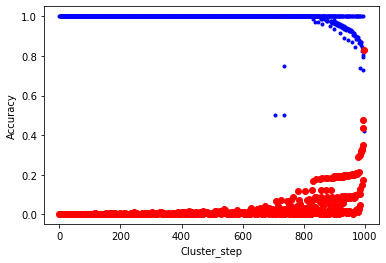

In [239]:
num_frames = np.array([len(i) for i in [[int(d) for d in [*k.split(',')]] for k in list(dic.keys())]],ndmin=2)
plt.scatter(range(len(accuracy)),accuracy,marker='.',color='b')
plt.scatter(range(num_frames.shape[1]),*(num_frames/num_frames.shape[1]).tolist(),color='r')
plt.xlabel('Cluster_step')
plt.ylabel('Accuracy')

In [189]:
for i in range(-10,0):
    print(len(all_clust[i]),'|',round(ave_rmsd[i],3),'|',round([*dic.values()][i],3))

125 | 0.586 | 758.328
79 | 0.602 | 758.101
25 | 0.571 | 758.08
12 | 0.78 | 757.833
89 | 0.599 | 757.629
16 | 0.541 | 757.625
185 | 0.632 | 757.6
12 | 0.656 | 757.5
191 | 0.579 | 757.257
2 | 0.971 | 757.0


In [112]:
len([*[*dic.keys()][99].split(',')])

897

## We will try k-means++ from here

In [376]:
Threshold = 0.6
traj = md.load_dcd('../proteinG_3gb1/yhalfres_0_0/trajectory.00.dcd',top='../proteinG_3gb1/3GB1.pdb')
topfile=traj.top
feat = coor.featurizer(topfile)
residues = np.arange(0,56)
pairs = []                                                                                 
for i,r1 in enumerate(residues):
    for r2 in residues[i+1::2]:
        pairs.append([r1,r2])
pairs = np.array(pairs)
feature=feat.add_residue_mindist(pairs, scheme='closest-heavy',threshold=Threshold,periodic=False)
inp = pyemma.coordinates.load('../proteinG_3gb1/yhalfres_0_0/trajectory.00.dcd', features=feat)
inp=inp[::10]
traj = traj[::10]

In [394]:
all_start = time.time()
all_input = list(itertools.combinations(inp, 2))
batch_size=1000000
inp_sliced=[all_input[i*batch_size:(i+1)*batch_size] for i in range(int(len(all_input)/batch_size))]
if int(len(inp_sliced)) < len(all_input)/batch_size:
    inp_sliced.append(all_input[len(inp_sliced)*batch_size:])
for i in range(len(inp_sliced)):
    temp_start = time.time()
    temp_c = np.zeros((int(len(inp_sliced[i])),3))
    temp_input = np.array(inp_sliced[i])
    product = temp_input.reshape(-1,2,temp_input.shape[-1]).sum(1)
    for row in range(3):
        temp_c[:,row] = np.sum(product==row,axis=1)
    if i == 0:
        all_c = temp_c
    else:
        all_c = np.concatenate((all_c,temp_c),axis=0)
    print('all_c shape =', all_c.shape)
    temp_end = time.time()
    temp_time = temp_end - temp_start
    print('step {} time ='.format(i),round(temp_time,2),'s')

###calculate similarity
simi = all_c[:,0]+all_c[:,2]
disimi = all_c[:,1]
denominate = all_c[:,0]+all_c[:,1]+all_c[:,2]
w_p = simi/denominate
simi_matrix = np.zeros((len(inp),len(inp)))
mirror_simi_matrix = np.zeros((len(inp),len(inp)))
upper_indices = np.triu_indices(len(inp),k=1)
lower_indices = (upper_indices[1],upper_indices[0])
simi_matrix[lower_indices] = simi
mirror_simi_matrix[upper_indices] = simi
mirror_simi_matrix[lower_indices] = simi
np.fill_diagonal(mirror_simi_matrix,np.Inf)
print('final matrix shape = ', simi_matrix.shape)
all_end = time.time()
all_time = all_end - all_start
print('total time =', round(all_time,2),'s')

all_c shape = (499500, 3)
step 0 time = 5.27 s
final matrix shape =  (1000, 1000)
total time = 5.35 s


In [403]:
#centroid = np.random.randint(0,len(inp),3)
centroid = [243,804,382]

In [408]:
### Assigning the most similar sample to each centroid
mirror_max_matrix = np.zeros((len(inp),len(inp)))
mirror_max_matrix[upper_indices] = simi
mirror_max_matrix[lower_indices] = simi
max_index = np.argmax(mirror_max_matrix[:,centroid],axis=0)
first_step = [[centroid[index],max_index[index]] for index in range(len(max_index))]
second_step_index = [i for i in range(inp.shape[0]) if i not in list(np.concatenate(first_step))]
print(first_step)

[[243, 215], [804, 793], [382, 914]]


In [409]:
md.rmsd(traj[np.concatenate(first_step)],pdb,atom_indices=all_CA)

array([0.87399685, 0.8820699 , 0.33895   , 0.33139157, 0.07938181,
       0.08370326], dtype=float32)

In [410]:
all_start = time.time()
k_clusters = [[243, 215], [804, 793], [382, 914]]
while len(second_step_index) > 0:
    random_int = np.random.randint(0,len(second_step_index))
    single = second_step_index[random_int]
    k_max = np.argmax([bc(np.concatenate(([inp[single]],inp[k_clusters[k]]),axis=0)).total_w_sim for k in range(len(k_clusters))],axis=None)
#    k_max = np.argmax([Fai(np.concatenate(([inp[single]],inp[k_clusters[k]]),axis=0)).Fai_1sim_wdis for k in range(len(k_clusters))],axis=None)
    k_clusters[k_max] = k_clusters[k_max] + [single]
    second_step_index.remove(single)
all_end = time.time()
all_time = all_end - all_start
print('total time =', round(all_time,2),'s')

total time = 4.08 s


In [411]:
print([len(i) for i in k_clusters])
[correct_ratio(md.rmsd(traj[i],pdb,atom_indices=all_CA)) for i in k_clusters]

[209, 140, 651]


[[0.8325, 0.0622, 0.0574, 0.0478, -0.0],
 [0.1143, 0.4643, 0.2857, 0.1286, 0.0071],
 [0.0952, 0.3518, 0.4562, 0.0968, 0.0]]

In [ ]:
### compare triple array
for k in range(len(first_step)):
    a=np.zeros((len(second_step_index),len(first_step[k])+1))
    a[:,0] = second_step_index
    a[:,[1,2]] = first_step[k]
    a=a.astype('int')
    all_input = [inp[i] for i in a]
    all_array_input = np.vstack([all_input])
    all_product = all_array_input.reshape(-1,3,all_array_input.shape[-1]).sum(1)
    temp_c = np.zeros((len(second_step_index),len(first_step[0])+2))
    for row in range(len(first_step[0])+2):
        temp_c[:,row] = np.sum(all_product==row,axis=1)
    if k == 0:
        all_c = temp_c
    else:
        all_c = np.concatenate((all_c,temp_c),axis=0)
        
### find centroids step by step
min_index = (np.argmin(mirror_simi_matrix[:,first_centroid]),first_centroid)
centroid = [first_centroid]
k=2
for i in range(k):
    ave_array = np.average(mirror_simi_matrix[:,centroid],axis=1)
    print(ave_array.shape)
    min_index = np.argmin(ave_array)
    centroid.append(min_index)
    print(centroid)
centroid